In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [206]:
files = {
    "category": '/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/category.csv',
    "products": '/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/products.csv',
    "sales": '/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/sales.csv',
    "stores": '/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/stores.csv',
    "warranty": '/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/warranty.csv'
}

## 1.Reload the files

In [207]:
df_cat = pd.read_csv(files["category"])
df_prod = pd.read_csv(files["products"])
df_sales = pd.read_csv(files["sales"])
df_stores = pd.read_csv(files["stores"])
df_warranty = pd.read_csv(files["warranty"])

## 2.Standardize Column Names 

In [208]:
df_prod.columns = ['product_id', 'product_name', 'category_id', 'launch_date', 'price']
df_stores.columns = ['store_id', 'store_name', 'city', 'country']

## 3. Data Type checking & convesrion

In [209]:
pd.DataFrame ({"Dtypes":df_prod.dtypes, "Num_unique":df_prod.nunique()   } ).T

,product_id,product_name,category_id,launch_date,price
Dtypes,object,object,object,object,int64
Num_unique,89,88,10,88,86


In [210]:
pd.DataFrame ({"Dtypes":df_sales.dtypes, "Num_unique":df_sales.nunique()   } ).T

,sale_id,sale_date,store_id,product_id,quantity
Dtypes,object,object,object,object,int64
Num_unique,1040200,1778,75,89,10


In [211]:
pd.DataFrame ({"Dtypes":df_warranty.dtypes, "Num_unique":df_warranty.nunique()   } ).T

,claim_id,claim_date,sale_id,repair_status
Dtypes,object,object,object,object
Num_unique,30000,317,30000,4


In [212]:
df_prod['launch_date'] = pd.to_datetime(df_prod['launch_date'])
df_sales['sale_date'] = pd.to_datetime(df_sales['sale_date'], format='%d-%m-%Y')
df_warranty['claim_date'] = pd.to_datetime(df_warranty['claim_date'])

## 4.Merge Dataframes

In [213]:
# Merge Sales with Products
df_merged = pd.merge(df_sales, df_prod, on='product_id', how='left')
# Merge with Categories
df_merged = pd.merge(df_merged, df_cat, on='category_id', how='left')
# Merge with Stores
df_merged = pd.merge(df_merged, df_stores, on='store_id', how='left')

## 5.calculate Revenue

In [214]:
df_merged['revenue'] = df_merged['quantity'] * df_merged['price']

In [215]:
# Extract Year and Month for time-series analysis

df_merged['sales_year']= df_merged['sale_date'].dt.year
df_merged['sales_month']= df_merged['sale_date'].dt.to_period('M')

## 6. Merge Warranty Data

In [216]:
# Merge Sales with Warranty (left join to keep all sales)
df_merged = pd.merge(df_merged, df_warranty[['sale_id', 'claim_id', 'claim_date', 'repair_status']], 
                     on='sale_id', how='left')


In [217]:
# Add a new coloumn for the sales who had a claim or not to be easier to count them
df_merged['has_warranty_claim'] = df_merged['claim_id'].notnull().astype(int)

In [218]:
df_merged['has_warranty_claim'].value_counts()

has_warranty_claim
0    1010200
1      30000
Name: count, dtype: int64

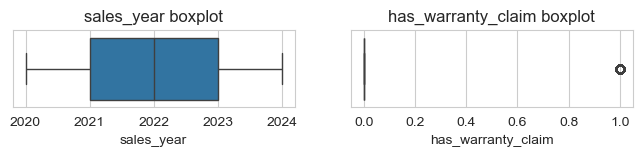

In [219]:
# check outliars
num_cols = df_merged.select_dtypes("int").columns
plt.figure(figsize=(8, 1))
for i, col in enumerate(num_cols):
    plt.subplot(1, 2, i+1)
    sns.boxplot(df_merged[col], orient="h")
    plt.title(f"{col} boxplot")

## 7. Save cleaned data

In [220]:
df_merged.to_csv("/Users/ahmedezzat/Downloads/Data Analysis/Apple Project/cleaned_merged_data.csv", index=False)

## 8. Report Analysis

In [221]:
analysis_report = []

total_revenue = df_merged['revenue'].sum()
total_quantity = df_merged['quantity'].sum()
num_sales = df_merged.shape[0]
avg_price = df_merged['price'].mean()
avg_quantity_per_sale = df_merged['quantity'].mean()

analysis_report.append(f"--- Overall Performance Metrics ---")
analysis_report.append(f"Total Revenue: ${total_revenue:,.2f}")
analysis_report.append(f"Total Units Sold: {total_quantity:,.0f}")
analysis_report.append(f"Total Number of Sales Transactions: {num_sales:,.0f}")
analysis_report.append(f"Average Product Price: ${avg_price:,.2f}")
analysis_report.append(f"Average Quantity per Transaction: {avg_quantity_per_sale:,.2f}")

In [222]:
# 2. Revenue by Category
revenue_by_category = df_merged.groupby('category_name')['revenue'].sum().sort_values(ascending=False)


In [223]:
# 3. Top 10 selling products
top_products_revenue = df_merged.groupby(['product_name', 'category_name'])['revenue'].sum().sort_values(ascending=False).head(10)

In [224]:
# 4. Sales Trend Over Time (Monthly) & (year)
monthly_sales = df_merged.groupby('sales_month')['revenue'].sum().reset_index()
monthly_sales['sales_month'] = monthly_sales['sales_month'].astype(str)

In [225]:
# 5. Performance by Store Location (Top 5 Countries)
revenue_by_country = df_merged.groupby('country')['revenue'].sum().sort_values(ascending=False).head(5)

In [226]:
warranty_claims_summary = df_merged.groupby('has_warranty_claim')['sale_id'].nunique().reset_index()

In [227]:
# 6. Warranty Analysis
warranty_claims_summary = df_merged.groupby('has_warranty_claim')['sale_id'].nunique()
warranty_claims_by_category = df_merged[df_merged['has_warranty_claim'] == 1].groupby('category_name')['claim_id'].nunique().sort_values(ascending=False)

total_sales_with_claim = warranty_claims_summary.get(1, 0)
total_sales = df_merged['sale_id'].nunique()
claim_rate = (total_sales_with_claim / total_sales) * 100 if total_sales > 0 else 0


## 9.Visualizations

In [228]:
# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

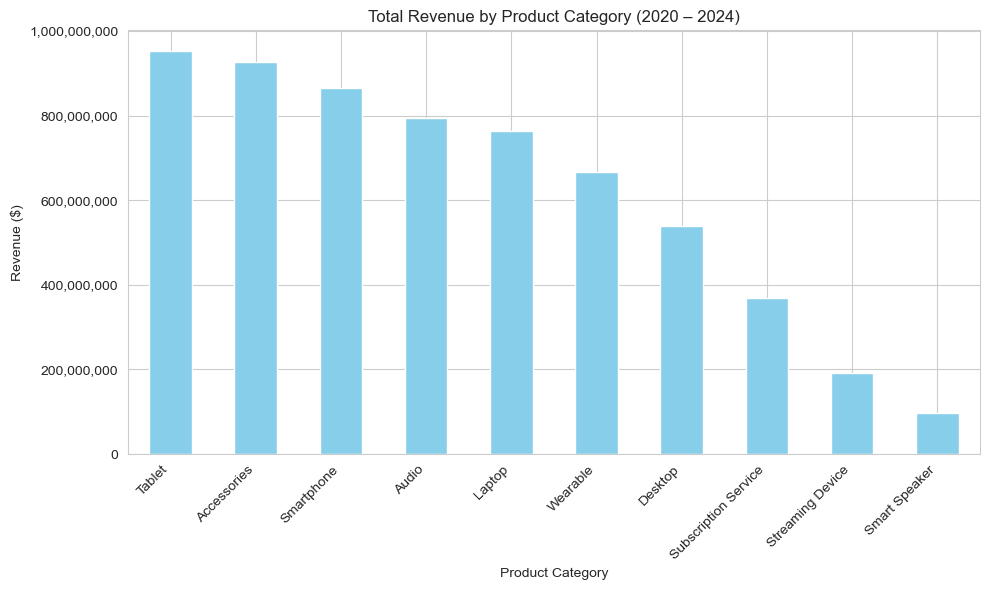

In [254]:
# 1.Total Revenue by Product Category (2020 – 2024)
import matplotlib.ticker as mtick

plt.figure()
ax = revenue_by_category.plot(kind='bar', color='skyblue')

plt.title('Total Revenue by Product Category (2020 – 2024)')
plt.ylabel('Revenue ($)')
plt.xlabel('Product Category')

# Show real numbers
ax.ticklabel_format(style='plain', axis='y')

# Format as comma-separated numbers (e.g., 1,200,000)
ax.get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()


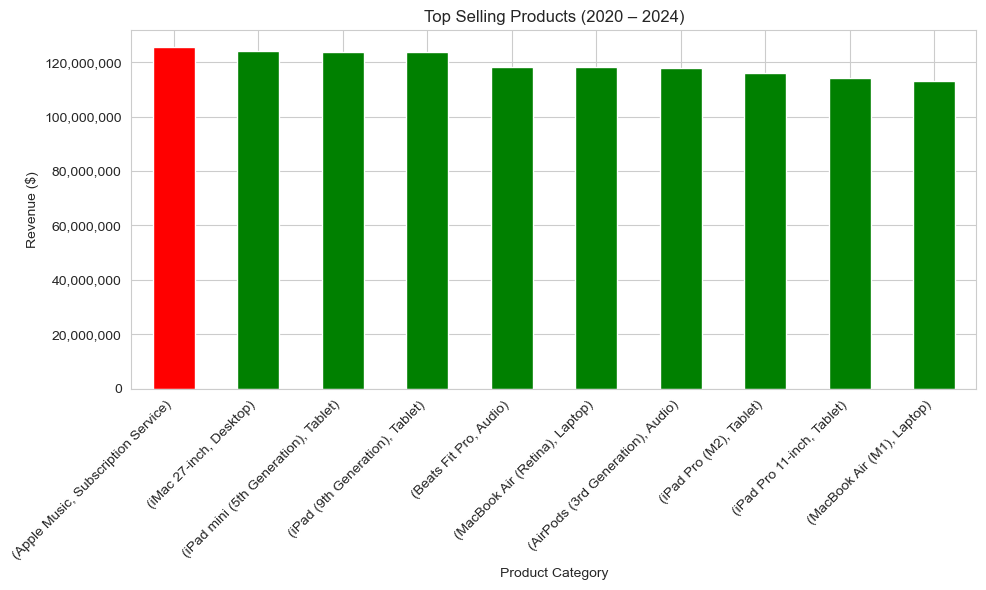

In [255]:
# 2.Total Revenue by Product (2020 – 2024)
#Make a list of colors: all green, except the top bar
colors = ['green' if val != top_products_revenue.max() else 'red' for val in top_products_revenue]

plt.figure()
ax = top_products_revenue.plot(kind='bar', color=colors)

plt.title('Top Selling Products (2020 – 2024)')
plt.ylabel('Revenue ($)')
plt.xlabel('Product Category')

# Show real numbers
ax.ticklabel_format(style='plain', axis='y')

# Format as comma-separated numbers
ax.get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [230]:
# 3. Monthly Sales Trend (Line Chart)
plt.figure()
monthly_sales_df = df_merged.groupby('sales_month')['revenue'].sum()
monthly_sales_df.index = monthly_sales_df.index.to_timestamp()
monthly_sales_df.plot(kind='line', marker='o', color='green')
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue (Millions $)')
plt.xlabel('Sale Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.close()

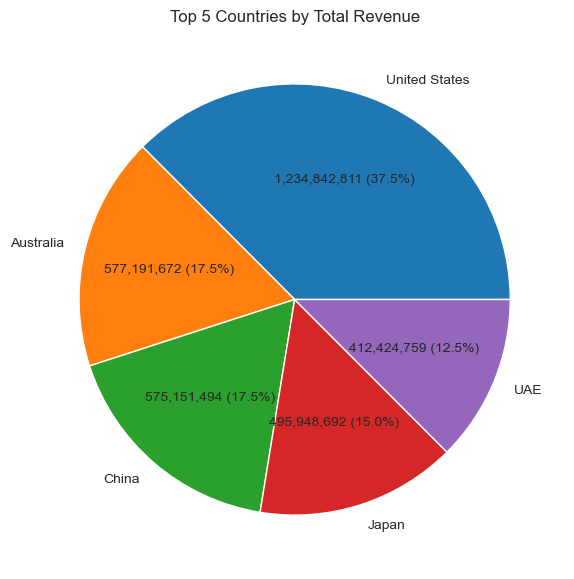

In [256]:
# 4.Top 5 Countries by Total Revenue

plt.figure(figsize=(7,7))

revenue_by_country.plot(
    kind='pie',
    autopct=lambda p: f'{int(p/100 * revenue_by_country.sum()):,} ({p:.1f}%)'
)
plt.title('Top 5 Countries by Total Revenue')
plt.ylabel('')
plt.show()
plt.close()

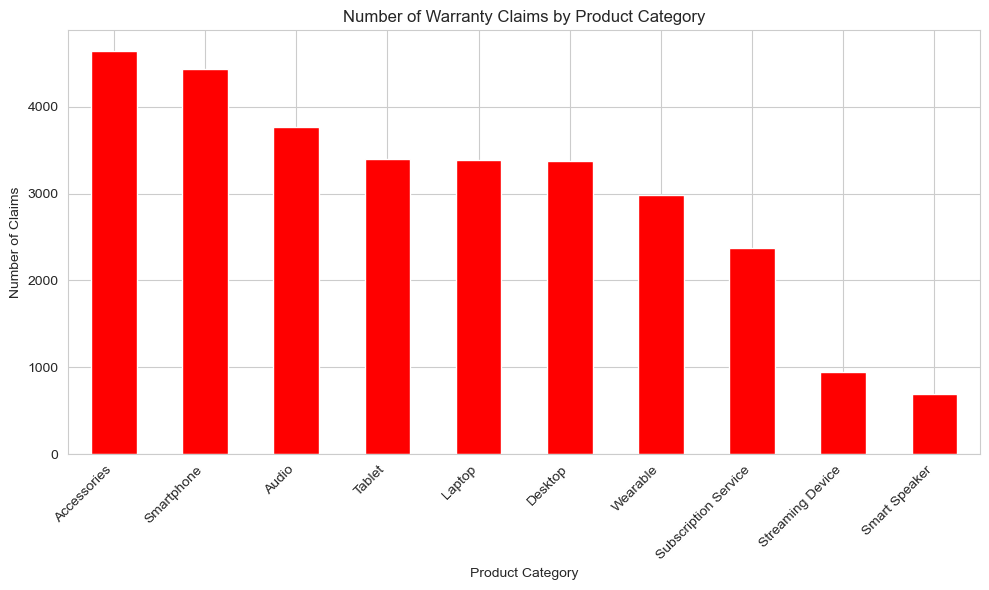

In [253]:
# 5.Number of Warranty Claims by Product Category

plt.figure()
warranty_claims_by_category.plot(kind='bar', color='red')
plt.title('Number of Warranty Claims by Product Category')
plt.ylabel('Number of Claims')
plt.xlabel('Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


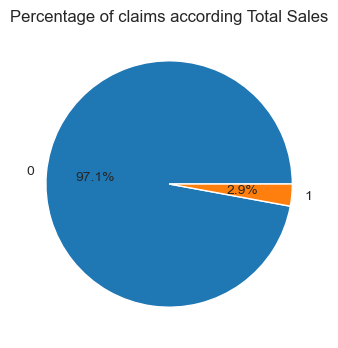

In [244]:
# 6.Percentage of claims according Total Sales
plt.figure(figsize=(4,4))

warranty_claims_summary.plot(kind='pie', autopct='%1.1f%%')

plt.title('Percentage of claims according Total Sales')
plt.ylabel('')
plt.show()

In [240]:
warranty_claims_summary

has_warranty_claim
0    1010200
1      30000
Name: sale_id, dtype: int64